---

Load libraries

---

In [1]:
## Load libraries
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from sklearn.metrics import confusion_matrix
plt.style.use('dark_background')
%matplotlib inline

---

Set printing precision

---

In [2]:
np.set_printoptions(precision = 2)

---

Mount Google drive

---

In [3]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    DIR = '/content/drive/MyDrive/Colab Notebooks/EvenSemester2024/DL/Codes'
    DATA_DIR = DIR + '/Data/'
else:
    DATA_DIR = 'Data/'

Mounted at /content/drive


---

Load MNIST Data

---

In [4]:
## Load MNIST data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

num_labels = len(np.unique(y_train))
num_features = X_train.shape[1]
num_samples = X_train.shape[0]

# One-hot encode class labels
Y_train = tf.keras.utils.to_categorical(y_train)
Y_test = tf.keras.utils.to_categorical(y_test)

# Normalize the samples (images) using the training data
xmax = np.amax(X_train) # 255
xmin = np.amin(X_train) # 0
X_train = (X_train - xmin) / (xmax - xmin) # all train features turn into a number between 0 and 1
X_test = (X_test - xmin) / (xmax - xmin)

print('MNIST set')
print('---------------------')
print('Number of training samples = %d'%(num_samples))
print('Number of features = %d'%(num_features))
print('Number of output labels = %d'%(num_labels))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MNIST set
---------------------
Number of training samples = 60000
Number of features = 784
Number of output labels = 10


---

We consider a 2-layer (or, a 1-hidden layer ReLU-activated) neural network with 128 nodes in the hidden layer for a batch comprising $b$ samples represented as the $b\times 784$-matrix $$\mathbf{X} = \begin{bmatrix}{\mathbf{x}^{(0)}}^\mathrm{T}\\{\mathbf{x}^{(1)}}^\mathrm{T}\\\vdots\\{\mathbf{x}^{(b-1)}}^\mathrm{T}\end{bmatrix}$$ with one-hot encoded true labels represented as the $b\times 10$-matrix (10 possible categories) $$\mathbf{Y}=\begin{bmatrix}{\mathbf{y}^{(0)}}^\mathrm{T}\\{\mathbf{y}^{(1)}}^\mathrm{T}\\\vdots\\{\mathbf{y}^{(b-1)}}^\mathrm{T}\end{bmatrix}.$$

The forward propagation for a generic sample in the batch seen as a $1\times784$-object $\mathbf{x}^\mathrm{T}$ with the bias feature $1$ added is presented below:

$$\small\begin{align*}
\boxed{\underbrace{\mathbf{x}_B^\mathrm{T}}_{1\times785}=\begin{bmatrix}\mathbf{x}^\mathrm{T}&1\end{bmatrix}}&\rightarrow\boxed{\underbrace{{\mathbf{z}^{[1]}}^\mathrm{T}}_{1\times 128} = \underbrace{\mathbf{x}_B^\mathrm{T}}_{1\times785}\underbrace{{\mathbf{W}^{[1]}}}_{785\times128}}\rightarrow\boxed{\underbrace{{\mathbf{a}^{[1]}}^\mathrm{T}}_{1\times 128}=\text{ReLU}\left(\underbrace{{\mathbf{z}^{[1]}}^\mathrm{T}}_{1\times128}\right)}\rightarrow\boxed{\underbrace{{\mathbf{a}^{[1]}_B}^\mathrm{T}}_{1\times129} = \begin{bmatrix}{\mathbf{a}^{[1]}}^\mathrm{T}&1\end{bmatrix}}\rightarrow\boxed{\underbrace{{\mathbf{z}^{[2]}}^\mathrm{T}}_{1\times10} = \underbrace{{\mathbf{a}^{[1]}_B}^\mathrm{T}}_{1\times129}\underbrace{\mathbf{W^{[2]}}}_{129\times10}}\rightarrow\boxed{\underbrace{{\mathbf{a}^{[2]}}^\mathrm{T}}_{1\times10}=\text{softmax}\left(\underbrace{{\mathbf{z}^{[2]}}^\mathrm{T}}_{1\times10}\right)}\rightarrow\boxed{L = \sum\limits_{k=0}^9-y_k\log\left(\hat{y}_k\right)}.
\end{align*}$$

The forward propagation for the same generic sample seen as a $784$-vector $\mathbf{x}$ with the bias feature $1$ added is presented below (note that the weight matrices have the same name $\mathbf{W}^{[1]}$ and $\mathbf{W}^{[2]}$ as above for simplicity even though they should show up as ${\mathbf{W}^{[1]}}^\mathrm{T}$ and ${\mathbf{W}^{[2]}}^\mathrm{T}$):

$$\small\begin{align*}
\boxed{\underbrace{\mathbf{x}_B}_{785}=\begin{bmatrix}\mathbf{x}\\1\end{bmatrix}}&\rightarrow\boxed{\underbrace{\mathbf{z}^{[1]}}_{128} = \underbrace{\mathbf{W}^{[1]}}_{128\times785}\underbrace{\mathbf{x}_B}_{785}}\rightarrow\boxed{\underbrace{\mathbf{a}^{[1]}}_{128}=\text{ReLU}\left(\underbrace{\mathbf{z}^{[1]}}_{128}\right)}\rightarrow\boxed{\underbrace{\mathbf{a}^{[1]}_B}_{129} = \begin{bmatrix}\mathbf{a}^{[1]}\\1\end{bmatrix}}\rightarrow\boxed{\underbrace{\mathbf{z}^{[2]}}_{10} = \underbrace{\mathbf{W^{[2]}}}_{10\times128}\underbrace{\mathbf{a}^{[1]}_B}_{128}}\rightarrow\boxed{\underbrace{\mathbf{a}^{[2]}}_{10}=\text{softmax}\left(\underbrace{\mathbf{z}^{[2]}}_{10}\right)}\rightarrow\boxed{L = \sum\limits_{k=0}^9-y_k\log\left(\hat{y}_k\right)}.
\end{align*}$$

The forward and backward propagation showing the gradient flow for a generic sample is shown below:

![](https://1drv.ms/i/c/37720f927b6ddc34/IQT4D2-PNgIeTKB8x227jLMIAffEyu1sRzJiNCK5MSORybU?width=1419&height=96)



---

---

A generic layer class with forward and backward methods

----

In [5]:
class Layer:
  def __init__(self):
    self.input = None
    self.output = None

  def forward(self, input):
    pass

  def backward(self, output_gradient, learning_rate):
    pass

---

CCE loss and its gradient for the batch samples

---

In [6]:
## Define the loss function and its gradient
def cce(Y, Yhat):
  return(np.mean(np.sum(-Y*np.log(Yhat), axis = 1), axis = 0))
  #TensorFlow in-built function for categorical crossentropy loss
  #cce = tf.keras.losses.CategoricalCrossentropy()
  #return(cce(Y, Yhat).numpy())

def cce_gradient(Y, Yhat):
  return(-Y/Yhat)

---

Generic pointwise activation class

---

In [7]:
class Activation(Layer):
  def __init__(self, activation, activation_gradient):
    self.activation = activation
    self.activation_gradient = activation_gradient

  def forward(self, input):
    self.input = input
    self.output = self.activation(self.input)
    return(self.output)

  def backward(self, output_gradient, learning_rate= None):
    local_gradient = self.activation_gradient(self.input)
    return(output_gradient[:, :-1] * local_gradient)

---

Specific pointwise activation layer classes

---

In [8]:
class ReLU(Activation):
  def __init__(self):
    def relu(z):
      return(z * (z>0))

    def relu_gradient(z):
      return(1.0 * (z>0))

    super().__init__(relu, relu_gradient)

class Sigmoid(Activation):
  def __init__(self):
    def sigmoid(z):
      return(1/(1+np.exp(-z)))

    def sigmoid_gradient(z):
      a = sigmoid(z)
      return(a * (1-a))

    super().__init__(sigmoid, sigmoid_gradient)


---

Softmax activation layer class


---

In [9]:
## Softmax activation layer class
class Softmax(Layer):
  def forward(self, input):
    self.input = input
    self.output = tf.nn.softmax(self.input, axis = 1).numpy()

  def backward(self, output_gradient, learning_rate = None):
    I = np.identity(self.output.shape[1])
    local_gradient = (I - self.output[:, :, np.newaxis]) * self.output[:, np.newaxis, :]
    return(np.einsum('ij,ijk->ik', output_gradient, local_gradient))

---

Dense layer class

---

In [10]:
## Dense layer class
class Dense(Layer):
    def __init__(self, input_size, output_size, reg_strength = 0.0):
        self.weights = 0.01*np.random.randn(input_size+1, output_size) # bias trick
        self.weights[-1, :] = 0.01 # set all bias values to the same nonzero constant
        self.reg_strength = reg_strength
        self.reg_loss = None

    def forward(self, input):
        self.input = np.hstack([input, np.ones((input.shape[0], 1))]) # bias trick
        # Forward propagation
        self.output= np.dot(self.input, self.weights)
        # Calculate regularization loss
        self.reg_loss = self.reg_strength * np.sum(self.weights[:-1, :] * self.weights[:-1, :])

    def backward(self, output_gradient, learning_rate):
        # Calculate gradient w.r.t. dense layer weights from all inputs
        weights_gradient = (1/output_gradient.shape[0]) * (np.einsum('ij,ik->jk', self.input, output_gradient))
        # Add the regularization gradient here
        weights_gradient += 2 * self.reg_strength * np.vstack([self.weights[:-1, :], np.zeros((1, self.weights.shape[1]))])
        # Calculate gradient flowing back on the input side of the dense layer
        input_gradient = np.dot(output_gradient, self.weights.T)
        # Update weights for dense layer
        self.weights = self.weights + learning_rate * (-weights_gradient)
        # Return gradient flowing back on the input side of the dense layer
        return(input_gradient)

---

Function to generate sample indices for batch processing according to batch size

---

In [11]:
## Function to generate sample indices for batch processing according to batch size
def generate_batch_indices(num_samples, batch_size):
  # Reorder sample indices
  reordered_sample_indices = np.random.choice(num_samples, num_samples, replace = False)
  # Generate batch indices for batch processing
  batch_indices = np.split(reordered_sample_indices, np.arange(batch_size, len(reordered_sample_indices), batch_size))
  return(batch_indices)

---

Example generation of batch indices

---

In [12]:
## Example generation of batch indices
batch_size = 16
batch_indices = generate_batch_indices(64, batch_size)
print(batch_indices)

[array([ 4, 35, 10, 54, 34, 30, 20, 15,  1, 17, 38,  2, 62, 57, 32,  8]), array([50, 46, 58, 27, 31, 26, 52, 40, 21, 47, 63, 49, 39,  5, 12, 33]), array([24, 13, 60,  7,  9, 11, 53, 48, 19, 56,  6, 28, 36, 37, 25, 29]), array([55, 45, 23, 42, 59, 61, 16, 43, 18, 41, 51, 22,  0,  3, 14, 44])]


---

Train the 2-layer neural network using batch training with batch size = 100

---

In [13]:
## Train the 1-layer neural network using batch training with batch size = 100
learning_rate = 1e-02
batch_size = 100
nepochs = 40
reg_strength = 0.1
# Create empty array to store training losses over each epoch
loss_train_epoch = np.empty(nepochs, dtype = np.float64)
# Create empty array to store test losses over each epoch
loss_test_epoch = np.empty(nepochs, dtype = np.float64)

# Neural network architecture ()
dlayer1 = Dense(num_features, 512, reg_strength)
alayer1 = ReLU()
dlayer2 = Dense(512, num_labels, reg_strength)
softmax = Softmax()

# Steps: run over each sample in the batch, calculate loss, gradient of loss,
# and update weights.
epoch = 0
# Run over each epoch
while epoch < nepochs:
  # Generate the batches
  batch_indices = generate_batch_indices(num_samples, batch_size)
  loss = 0
  # Run over each batch of samples
  for b in range(len(batch_indices)):
    # Forward prop starts here
    dlayer1.forward(X_train[batch_indices[b], :])
    alayer1.forward(dlayer1.output)
    dlayer2.forward(alayer1.output)
    softmax.forward(dlayer2.output)
    loss+= cce(Y_train[batch_indices[b],:], softmax.output)
    # Add the regularization losses
    loss = loss + dlayer1.reg_loss + dlayer2.reg_loss
    # Forward prop ends and backward prop starts here
    grad = cce_gradient(Y_train[batch_indices[b], :], softmax.output)
    grad = softmax.backward(grad)
    grad = dlayer2.backward(grad, learning_rate)
    grad = alayer1.backward(grad)
    grad = dlayer1.backward(grad, learning_rate)
  # Calculate the average training loss for the current epoch
  loss_train_epoch[epoch] = loss/len(batch_indices)

  # Forward propagation for test data
  dlayer1.forward(X_test)
  alayer1.forward(dlayer1.output)
  dlayer2.forward(alayer1.output)
  softmax.forward(dlayer2.output)

  # Calculate test data loss plus regularization loss
  loss_test_epoch[epoch] =  cce(Y_test, softmax.output) + dlayer1.reg_loss + dlayer2.reg_loss

  print('Epoch %d: train loss = %f, test loss = %f'%(epoch+1, loss_train_epoch[epoch], loss_test_epoch[epoch]))
  epoch = epoch + 1

Epoch 1: train loss = 3.767232, test loss = 2.492851
Epoch 2: train loss = 2.182040, test loss = 2.006428
Epoch 3: train loss = 1.984427, test loss = 1.949642
Epoch 4: train loss = 1.958509, test loss = 1.937135
Epoch 5: train loss = 1.949719, test loss = 1.930864
Epoch 6: train loss = 1.944326, test loss = 1.925567
Epoch 7: train loss = 1.940337, test loss = 1.921995
Epoch 8: train loss = 1.936947, test loss = 1.918723
Epoch 9: train loss = 1.934401, test loss = 1.916507
Epoch 10: train loss = 1.932260, test loss = 1.915113
Epoch 11: train loss = 1.930351, test loss = 1.912260
Epoch 12: train loss = 1.928546, test loss = 1.911597
Epoch 13: train loss = 1.927165, test loss = 1.909630
Epoch 14: train loss = 1.925876, test loss = 1.908268
Epoch 15: train loss = 1.924761, test loss = 1.907845
Epoch 16: train loss = 1.923884, test loss = 1.906039
Epoch 17: train loss = 1.922913, test loss = 1.905386
Epoch 18: train loss = 1.922052, test loss = 1.905308
Epoch 19: train loss = 1.921281, test

---

Plot training and test loss vs. epoch

---

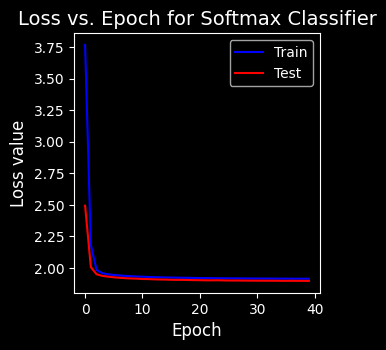

In [14]:
## Plot train and test loss as a function of epoch:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
fig.tight_layout(pad = 4.0)
ax.plot(loss_train_epoch, 'b', label = 'Train')
ax.plot(loss_test_epoch, 'r', label = 'Test')
ax.set_xlabel('Epoch', fontsize = 12)
ax.set_ylabel('Loss value', fontsize = 12)
ax.legend()
ax.set_title('Loss vs. Epoch for Softmax Classifier', fontsize = 14);

---

Assess model performance on test data

---

In [15]:
## Assess model performance on test data
dlayer1.forward(X_test)
alayer1.forward(dlayer1.output)
dlayer2.forward(alayer1.output)
softmax.forward(dlayer2.output)
ypred = np.argmax(softmax.output, axis = 1)
ytrue = np.argmax(Y_test, axis = 1)
print('Accuracy on test data = %3.2f'%(np.mean(ytrue == ypred)*100))
# Print confusion matrix
print(confusion_matrix(ytrue, ypred))

Accuracy on test data = 77.30
[[ 939    1    3    5    0   13   15    3    1    0]
 [   0 1126    4    3    0    0    2    0    0    0]
 [  24   92  786   41   25    0   41   17    6    0]
 [  11   41   31  859    1   22    1   25   11    8]
 [   1   25    1    0  740    0   33    6    2  174]
 [  61   71   16  234   19  359   40   51    7   34]
 [  22   30   17    2   18   12  854    1    2    0]
 [   3   65   16    1   10    0    0  909    1   23]
 [  30   94   31  143   23   15   19   19  544   56]
 [  18   27    5   10  225    5    2  100    3  614]]


Image classified as 8


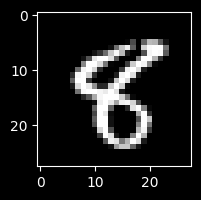

In [16]:
## Plot a random test sample with its predicted label printed above the plot
test_index = np.random.choice(X_test.shape[0])
fig, ax = plt.subplots(1, 1, figsize = (2, 2))
print(f'Image classified as {ypred[test_index]}')
ax.imshow(tf.reshape(X_test[test_index], [28, 28]).numpy(), cmap = 'gray');